##  Proyecto Capstone - La Batalla de los Vecindarios (Semana 2)

### Introducción/Problema Comercial

La ciudad de Nueva York muestra que es una de las mayores metrópolis del planeta. Es la capital económica del mundo donde todos los días las mayores compañías del mundo dirigen sus negocios desde esta urbe. Nueva York, con 8,3 millones de habitantes en 2019, es de las ciudades con mayor actividad del mundo, sin embargo su agitada forma de vida puede traer consigo problemas en la salud mental de sus habitantes.Depresión, estrés, ansiedad son algunos problemas frecuentes que padecen los neoyorquinos. Según estudios especializados presentados por el Departamento de Salud de esa ciudad en el año 2016, 8% de los residentes de Nueva York sufren síntomas de depresión, uno de los varios problemas mentales que afectan a uno de cada cinco neoyorquinos.

Así mismo, New York es una de las ciudades más estresantes del mundo. William Russell, un proveedor internacional de seguros de salud, vida y protección de ingresos, realizó un estudio en 2022 que sitúa a esta ciudad más estresante de los Estados Unidos.

Están aumentando los estudios que demuestran que la práctica del yoga puede ayudar con la depresión y la ansiedad; problemas de salud mental. Un estudio  publicado en 2020 por el British Journal of Sports Medicine, ha descubierto que practicar sesiones de yoga puede mejorar los síntomas de la depresión en personas con una variedad de problemas mentales; además, practicar más sesiones por semana resultó con una disminución más significativa de los síntomas.

En distintos estudios, también demuestran que el yoga puede ayudar a reducir el estrés y la ansiedad. El yoga puede mejorar el estado de ánimo y la sensación general de bienestar.

El objetivo de este proyecto final es analizar y seleccionar las mejores ubicaciones en la ciudad de Nueva York para abrir un nuevo estudio de yoga  mediante el análisis y la visualización de datos. El proyecto es particularmente útil para quienes desean realizar emprendimientos de esta naturaleza en la ciudad de Nueva York.

### Datos

Para llevar a cabo este proyecto final, se requieren los siguientes datos de la ciudad de Nueva York:

1. Datos de la ciudad de Nueva York relacionados con vecindarios y distritos.

2. Coordenadas de latitud y longitud de los vecindarios.

3. Datos de estudios de yoga existentes en la ciudad de Nueva York.

Los datos de la ciudad de Nueva York relacionados con los vecindarios y distritos se pueden obtener de la fuente de datos abierta (https://cocl.us/new_york_dataset) y las coordenadas geográficas de los vecindarios, como la latitud y la longitud, del paquete Python Geocoder. La API de Foursquare será necesaria para obtener datos de lugares de los vecindarios de la ciudad de Nueva York.

### Metodología

1. Los datos se obtendrán de la fuente de datos abierta (https://cocl.us/new_york_dataset) y se limpiarán/procesarán en un marco de datos.

2.Foursquare se utilizará para los datos del lugar y se filtrará por estudios de yoga.

3. Los datos se ordenarán según las clasificaciones.

4. Los datos se visualizarán utilizando la biblioteca Python Folium.

importación de todas las bibliotecas requeridas

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import os
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv

Estableciendo coordenadas

In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Credenciales

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Obtener datos de vecindarios de la ciudad de Nueva York

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Obtener lisa de estudios de yoga existentes en la ciudad de Nueva York

In [8]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
yoga_studio_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    yoga_studios=venues[venues['Category']=='Yoga Studio']   
    print('(',count,'/',len(new_york_data),')','Yoga Studios in '+Neighborhood+', '+Borough+':'+str(len(yoga_studios)))
    for gym_detail in yoga_studios.values.tolist():
        id, name , category=gym_detail
        yoga_studio_ny = yoga_studio_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Yoga Studios in Wakefield, Bronx:0
( 2 / 306 ) Yoga Studios in Co-op City, Bronx:0
( 3 / 306 ) Yoga Studios in Eastchester, Bronx:0
( 4 / 306 ) Yoga Studios in Fieldston, Bronx:0
( 5 / 306 ) Yoga Studios in Riverdale, Bronx:0
( 6 / 306 ) Yoga Studios in Kingsbridge, Bronx:1
( 7 / 306 ) Yoga Studios in Marble Hill, Manhattan:1
( 8 / 306 ) Yoga Studios in Woodlawn, Bronx:0
( 9 / 306 ) Yoga Studios in Norwood, Bronx:0
( 10 / 306 ) Yoga Studios in Williamsbridge, Bronx:0
( 11 / 306 ) Yoga Studios in Baychester, Bronx:0
( 12 / 306 ) Yoga Studios in Pelham Parkway, Bronx:1
( 13 / 306 ) Yoga Studios in City Island, Bronx:0
( 14 / 306 ) Yoga Studios in Bedford Park, Bronx:0
( 15 / 306 ) Yoga Studios in University Heights, Bronx:0
( 16 / 306 ) Yoga Studios in Morris Heights, Bronx:0
( 17 / 306 ) Yoga Studios in Fordham, Bronx:0
( 18 / 306 ) Yoga Studios in East Tremont, Bronx:0
( 19 / 306 ) Yoga Studios in West Farms, Bronx:0
( 20 / 306 ) Yoga Studios in High  Bridge, Bronx:0
( 21 /

Guardar datos en un archivo CSV

In [9]:
yoga_studio_ny.to_csv('yoga_studio_ny_data.csv')
yoga_ny = pd.read_csv('yoga_studio_ny_data.csv')
yoga_studio_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,4baf59e8f964a520a6f93be3,Bikram Yoga
1,Manhattan,Marble Hill,4baf59e8f964a520a6f93be3,Bikram Yoga
2,Bronx,Pelham Parkway,4d5c4633524fa35d8dab4735,Bronx Dahn Yoga Center
3,Brooklyn,Bay Ridge,4b32d9d5f964a520071525e3,Bikram Yoga
4,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga


In [27]:
yoga_studio_ny.shape

(124, 4)

Número de estudios de yoga en Nueva York por distrito

In [28]:
yoga_studio_ny.groupby('Borough')['ID'].count()

Borough
Bronx             3
Brooklyn         67
Manhattan        35
Queens           15
Staten Island     4
Name: ID, dtype: int64

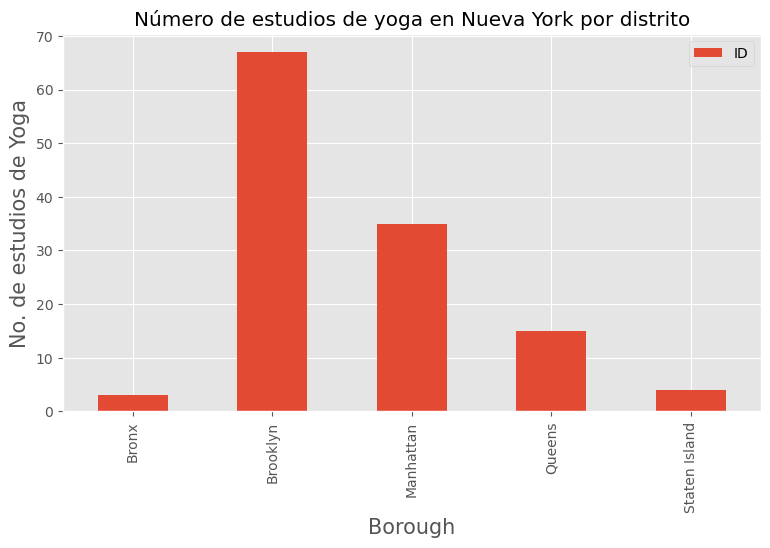

In [10]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Número de estudios de yoga en Nueva York por distrito')
#On x-axis
plt.xlabel('Distrito', fontsize = 15)
#On y-axis
plt.ylabel('No. de estudios de Yoga', fontsize=15)
#giving a bar plot
yoga_studio_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Número de estudios de yoga en Nueva York por barrio

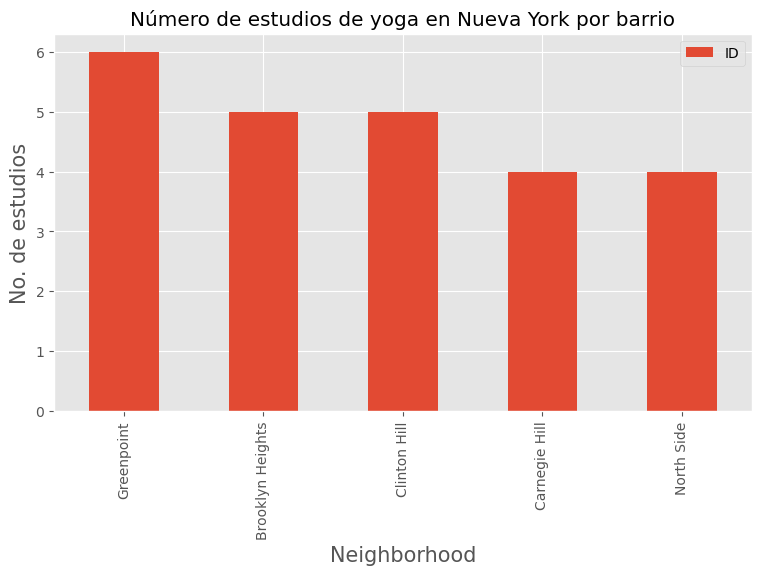

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Número de estudios de yoga en Nueva York por barrio')
plt.xlabel('Barrio', fontsize = 15)
plt.ylabel('No. de estudios', fontsize=15)
yoga_studio_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

Ranking de cada estudio de yoga para su posterior análisis

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
yoga_studio_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in yoga_studio_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
yoga_studio_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in yoga_studio_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(yoga_studio_ny),')','processed')
    yoga_studio_stats_ny = yoga_studio_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID         Name  Likes  Rating  Tips
0  4baf59e8f964a520a6f93be3  Bikram Yoga     23     8.8     5
( 1 / 124 ) processed
                         ID         Name  Likes  Rating  Tips
0  4baf59e8f964a520a6f93be3  Bikram Yoga     23     8.8     5
( 2 / 124 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d5c4633524fa35d8dab4735
( 3 / 124 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b32d9d5f964a520071525e3  Bikram Yoga     18     7.2     5
( 4 / 124 ) processed
                         ID      Name  Likes  Rating  Tips
0  4a9a86dcf964a520cc3120e3  goodyoga     30     9.1     7
( 5 / 124 ) processed
                         ID           Name  Likes  Rating  Tips
0  55b51009498e4c7fd1fea655  New Love City     37     8.9     9
( 6 / 124 ) processed
                         ID       Name  Likes  Rating  Tips
0  5172d6477043c222fb3a8b97  Maha Rose     30     8.8     3
( 7 / 124 ) 

Guardar datos en un archivo CSV

In [14]:
yoga_studio_stats_ny.to_csv('yoga_studio_stats_ny_data.csv') 

In [15]:
yoga_studio_stats_ny.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,4baf59e8f964a520a6f93be3,Bikram Yoga,23,8.8,5
1,Manhattan,Marble Hill,4baf59e8f964a520a6f93be3,Bikram Yoga,23,8.8,5
2,Bronx,Pelham Parkway,0,0,0,0.0,0
3,Brooklyn,Bay Ridge,4b32d9d5f964a520071525e3,Bikram Yoga,18,7.2,5
4,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga,30,9.1,7
5,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City,37,8.9,9
6,Brooklyn,Greenpoint,5172d6477043c222fb3a8b97,Maha Rose,30,8.8,3
7,Brooklyn,Greenpoint,4be738c8bcef2d7fe10606e5,Usha Veda Yoga,23,8.6,8
8,Brooklyn,Greenpoint,4b79ee03f964a520e31a2fe3,hosh yoga,20,8.8,0
9,Brooklyn,Greenpoint,56b22714498e31102864ef29,Lucent Yoga,14,8.3,7


Convertir valores string a valores flotantes

In [16]:
yoga_studio_stats_ny['Likes'] = yoga_studio_stats_ny['Likes'].astype('float64')
yoga_studio_stats_ny['Tips'] = yoga_studio_stats_ny['Tips'].astype('float64')
yoga_studio_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       124 non-null    object 
 1   Neighborhood  124 non-null    object 
 2   ID            124 non-null    object 
 3   Name          124 non-null    object 
 4   Likes         124 non-null    float64
 5   Rating        124 non-null    float64
 6   Tips          124 non-null    float64
dtypes: float64(3), object(4)
memory usage: 6.9+ KB


In [17]:
yoga_studio_stats_ny.describe()

,Likes,Rating,Tips
count,124.000000,124.000000,124.000000
mean,33.645161,7.883871,7.354839
std,42.802856,2.020078,7.954335
min,0.000000,0.000000,0.000000
25%,9.750000,7.900000,2.000000
50%,23.000000,8.500000,5.000000
75%,39.250000,8.825000,10.000000
max,321.000000,9.200000,49.000000


Analisis de valoraciones

In [18]:
ny_neighborhood_stats=yoga_studio_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
67,Upper West Side,9.200000
69,West Village,9.000000
64,Tribeca,9.000000
57,Ravenswood,9.000000
48,Midtown South,9.000000
36,Greenwich Village,8.933333
27,Flatiron,8.900000
12,Chelsea,8.900000
17,Crown Heights,8.800000
62,Steinway,8.800000


In [19]:
ny_borough_stats=yoga_studio_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.620000
1,Brooklyn,8.143284
3,Queens,7.513333
0,Bronx,5.866667
4,Staten Island,0.000000


Todos los barrios con valoración media superior o igual a 8,0 para visualizar en mapa

In [22]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats.head()


,Neighborhood,Average Rating
0,Astoria,8.80
5,Boerum Hill,8.60
7,Brooklyn Heights,8.64
8,Bushwick,8.70
9,Carnegie Hill,8.60


In [23]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Borough,Neighborhood,Latitude,Longitude,Average Rating
41,Manhattan,Upper West Side,40.787658,-73.977059,9.200000
43,Manhattan,West Village,40.734434,-74.006180,9.000000
38,Manhattan,Tribeca,40.721522,-74.010683,9.000000
34,Queens,Ravenswood,40.761705,-73.931575,9.000000
29,Manhattan,Midtown South,40.748510,-73.988713,9.000000
21,Manhattan,Greenwich Village,40.726933,-73.999914,8.933333
15,Manhattan,Flatiron,40.739673,-73.990947,8.900000
7,Manhattan,Chelsea,40.744035,-74.003116,8.900000
8,Staten Island,Chelsea,40.594726,-74.189560,8.900000
0,Queens,Astoria,40.768509,-73.915654,8.800000


Crear mapa

In [24]:
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)
incidents = folium.map.FeatureGroup()
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Los vecindarios de Nueva York que tienen la calificación promedio más alta para estudios de yoga

In [25]:

for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)

### Resultados y Discusión

Exisen 124 estudios de yoga en toda la ciudad de Nueva York. El distrito de Broklyn tiene la mayor cantidad de establecimientos de este tipo (67 estudios de yoga), seguido de Manhattan (47 estudios de yoga) y  Queens (42 estudios de yoga).
El barrio de Green Point, en el distrito de Brooklyn, tiene la mayor cantidad de establecimientos de este tipo (6 estudios de yoga). 

Manhattan es el distrito con mejor promedio de calificacion con 8.620000 puntos. Por su parte el barrio de Upper West Side	tiene el mejor promedio de calificacion con  9.200000 puntos.

### Conclusiones

Según el análisis de los datos, el mejor lugar para establecer un nuevo estudio de Yoga es el distrito de Manhattan. Tiene un 30% menos de estudios de yoga que el distrito de Brooklyn, así que no existe tanta saturación de centros de este tipo. Tiene el mejor promedio calificacion por lo que los mejores estudios de yoga se encuentran en esta zona. Manhattan es el centro de la ciudad de Nueva York y tiene una población de más de  1.5 millones de habitantes.